## Deep Learning with TensorFlow for Sentiment Analysis

In this homework, our task and dataset are the same as the previous homework; classifying movie reviews into positive and negative sentiment groups. 

Similar to the first homework, we will count the number of occurences of each lemmatized word in each document. We will use these counts as features characterizing the documents. These features will be fed into a neural network with two hidden layers. In preproecssing step, we use `spacy`, `nltk`, `contractions`, and `beautifulsoup4` libraries for performing these actions to get a clean corpus:

- stripping html tags
- removing urls
- removing accented characters
- expand contractions
- remove tweets (mentions)
- removes punctuations
- removing stop words
- converting all words to lowercase

Textual data is generally modelled better using sequential models such as a recurrent neural network. However, [Google guidelines](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) note that bag-of-words (n-gram) models perform better or comparably to sequential models when a certain ratio exists in the dataset between the length of the documents and the number of words per document in the corpus. We will analyze this in [Section 1](#dataset_stats).

### Sections of The Notebook
1. [Loading Dataset and Basic Statistics](#dataset_stats)
2. [Counting Words](#word_counts)
3. [Train/Test Set Summary After Preprocessing](#data_summary)
4. [Building Neural Network Model](#model)
5. [Exercise](#exercise)

In [1]:
import tarfile
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers

import preprocess  # preprocessing functions for cleaning text
import utils  # read data, populate train/test setsplt.style.use("ggplot")

<a id=dataset_stats> </a>
## 1. Loading Dataset and Basic Statistics

We are reading in the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/). Refer to homework 1 for details about the dataset.


When the value for this ratio is small (<1500), small multi-layer perceptrons that take n-grams as input (which we'll call Option A) perform better or at least as well as sequence models. 

In [2]:
# path specification for the files
ARCHIVE_NAME = "./data/aclImdb_v1.tar.gz"
    
with tarfile.open(ARCHIVE_NAME, "r:gz") as tar:
    X_train, y_train, X_test, y_test = utils.get_raw_data_from(tar)

We define a helper function below to plot the distribution of document lengths.

In [3]:
def plot_sample_length_distribution(texts):
    """Plots the sample length distribution

    :param texts: list of texts
    :returns: None
    :rtype: None

    """
    plt.hist([len(s) for s in texts], 50)
    plt.xlabel("Length of a sample")
    plt.ylabel("Number of samples")
    plt.title("Sample length distribution")
    plt.show()    

### Sample length distribution for training set

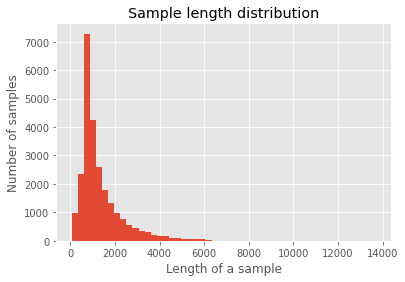

In [4]:
plot_sample_length_distribution(X_train)

### Sample length distribution for test set

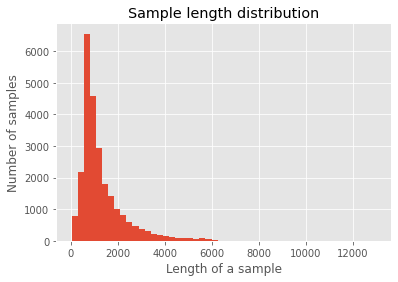

In [5]:
plot_sample_length_distribution(X_test)

We define a helper function to calculate the median number of words in documents below.

In [6]:
def get_num_words_per_sample(texts):
    """Returns the median number of words per sample
    
    :param texts: list of texts
    :returns: median of number of words per sample
    :rtype: int

    """
    num_words = [len(s.split()) for s in texts]

    return int(np.median(num_words))

In [7]:
print("{:50s}: {}".format("Number of words per sample in training (median)", get_num_words_per_sample(X_train)))
print("{:50s}: {}".format("Number of words per sample in test (median)", get_num_words_per_sample(X_test)))

Number of words per sample in training (median)   : 174
Number of words per sample in test (median)       : 172


We have $25000$ samples in the training set and $174$ words per document. $25000/174 \approx 144 < 1500$. According to the Google guideline, we can get good results using a fully connected neural network with word counts.

<a id=word_counts></a>
## 2. Counting words

We are tokenizing and getting the unigram counts. We will only keep the words that occur in at least 20 of the documents in the corpus. This will reduce the feature set size.

In [8]:
vectorizer = CountVectorizer(tokenizer=utils.tokenizer, ngram_range=(1,1), min_df=20)
%time X_train_cnt = vectorizer.fit_transform(X_train)
%time X_test_cnt = vectorizer.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

CPU times: user 9min 23s, sys: 475 ms, total: 9min 23s
Wall time: 9min 24s
CPU times: user 8min 47s, sys: 152 ms, total: 8min 47s
Wall time: 8min 48s


<a id=data_summary></a>
## 3. Train/Test Set Summary After Preprocessing

Here, we have a simple summary about train/test sets that can help us to understand the dataset and the type of classification problem that we have

In [9]:
print("{:50s}: {}".format("Number of training set samples", X_train_cnt.shape[0]))
print("{:50s}: {}".format("Number of test set samples", X_test_cnt.shape[0]))

y_train_cnt = Counter(y_train)
y_test_cnt = Counter(y_test)

train_sample_cnt = ", ".join([f"{k}:{y_train_cnt[k]}" for k in sorted(y_train_cnt)])
test_sample_cnt = ", ".join([f"{k}:{y_test_cnt[k]}" for k in sorted(y_test_cnt)])
print("{:50s}: {:10s}".format("Number of samples per class in training set", train_sample_cnt))
print("{:50s}: {:10s}".format("Number of samples per class in test set", test_sample_cnt))
assert X_train_cnt.shape[1] == X_test_cnt.shape[1]
print("{:50s}: {}".format("Number of word in vocabulary", X_train_cnt.shape[1]))

Number of training set samples                    : 25000
Number of test set samples                        : 25000
Number of samples per class in training set       : 0:12500, 1:12500
Number of samples per class in test set           : 0:12500, 1:12500
Number of word in vocabulary                      : 9786


<a id=model></a>
## 4. Building Neural Network Model

We are going to use fully connected neural network model. We will use sigmoid activation at the output layer since we only have two classes.

TensorFlow allows [functional](https://www.tensorflow.org/guide/keras/functional) and [sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) API. We will use the sequential API. 


TensorFlow has many different [optimization algorithms](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). We will use Adam. To avoid overfitting, there are several regularization alternatives. We will use dropout strategy and early stopping.

In [15]:
def _form_last_layer(num_classes):
    """Forms the classification layer and sets activation function

    :param num_classes: number of classes
    :returns: units, activation
    :rtype: tuple

    """
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    elif num_classes > 2:
        activation = "softmax"
        units = num_classes
    else:
        raise Exception("Number of classes should be at least 2.")
        
    return units, activation


def build_mlp(num_layers, units, dropout_rate, input_shape, num_classes):
    """defines a fully connected neural network based on num_layers and units in each layer

    :param num_layers: number of hidden layers
    :param units: list of number of hidden units
    :param dropout_rate: probability of dropping out unit
    :param input_shape: input feature size in tuple
    :param num_classes: number of classes
    :returns: model
    :rtype: tf.keras.models.Sequential

    """
    model = tf.keras.models.Sequential()

    model.add(layers.Dropout(rate=dropout_rate, input_shape=input_shape))

    # for each layer
    for i in range(num_layers - 1):

        # add a fully connected layer
        model.add(layers.Dense(units=units[i], activation="relu"))
        # with a dropout rate of `dropout_rate`
        model.add(layers.Dropout(rate=dropout_rate))

    # get the output layer units and activation function
    o_units, o_activation = _form_last_layer(num_classes)

    # and add it to the model
    model.add(layers.Dense(units=o_units, activation=o_activation))

    return model

In [16]:
# obtain the number of distinct classes
# from the training labels
num_classes=len(set(y_train))

# build the neural network model with 
# 1 input + 2 hidden + 1 output layer
model = build_mlp(
    
    num_layers=3,
    # hidden layers have 64 and 32 units
    units=[64, 32],
    
    # each unit can be dropped out 
    # with a probability of 0.3
    dropout_rate=0.3,
    # input shape will be the size of the vocabulary
    input_shape=X_train_cnt.shape[1:],
    
    num_classes=num_classes
)

# Compile model with learning parameters.
if num_classes == 2:
    # for two classes loss function is `binary_crossentropy`
    loss = "binary_crossentropy"
else:
    # for more than two classes, we use `sparse_categorical_crossentropy`
    loss = "sparse_categorical_crossentropy"


optimizer = tf.keras.optimizers.Adam(lr=1e-3)
# we will report accuracy (`acc`) during training
model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

# early stopping will depend on the validation loss
# patience parameter determines how many epochs with no improvement
# in validation loss will be tolerated
# before training is terminated.
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)]

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 9786)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                626368    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 628,481
Trainable params: 628,481
Non-trainable params: 0
________________________________________________

In [18]:
history = model.fit(
    X_train_cnt.todense(),
    y_train,
    # keep 10% of the training data for validation
    validation_split=0.1,
    epochs=32,
    callbacks=callbacks,
    verbose=2,  # Logs once per epoch.
    batch_size=128,
    # Our neural network will be trained 
    # with stochastic (mini-batch) gradient descent. 
    # It is important that we shuffle our input.
    shuffle=True # set to True by default
)

# Print training history
history = history.history
print(
    "\nValidation accuracy: {acc}, loss: {loss}".format(
        acc=history["val_acc"][-1], loss=history["val_loss"][-1]
    )
)

Epoch 1/32
176/176 - 3s - loss: 0.2161 - acc: 0.9139 - val_loss: 0.5093 - val_acc: 0.8000
Epoch 2/32
176/176 - 3s - loss: 0.1892 - acc: 0.9248 - val_loss: 0.5705 - val_acc: 0.7864
Epoch 3/32
176/176 - 3s - loss: 0.1688 - acc: 0.9344 - val_loss: 0.5675 - val_acc: 0.7860

Validation accuracy: 0.7860000133514404, loss: 0.5675308704376221


### Model Performance Metrics

In [19]:
y_test_pred = (model.predict(X_test_cnt, batch_size=128) > 0.5).astype("int32")
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     12500
           1       0.89      0.82      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



<a id=exercise></a>
## 5. Exercise

#### 1. TF-IDF is a metric that reflects importance of words better than mere counts. Train the neural network above with [sklearn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Report model performance metrics on the test set.

#### 2. Experiment with the number of hidden layers, number of units in the hidden layers and the dropout rate. Report model performance metrics on the test set.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Please contact Haluk Dogan (<a href="mailto:hdogan@vivaldi.net">hdogan@vivaldi.net</a>) for further questions or inquries.